# Machine Learning for Stock Price Prediction

## Loading training data

In [1]:
import pandas as pd 
import numpy as np


### Function for data pre-processing of train and test data

In [2]:
df_train = pd.read_csv('../data/pre-processed-train-data.csv')
df_val = pd.read_csv('../data/Stock-price-data-validation-2023.csv')
df_test = pd.read_csv('../data/Stock-price-data-test-2023.csv')



## ARIMA Model

In [3]:
from statsmodels.tsa.arima.model import ARIMA

# Function to train ARIMA model
def train_arima(data):
    
    # p = 5  -  Uses the past 5 lagged observations to predict the current value.
    # q = 1  -  The time series is differenced once to make it stationary.
    # d = 0  -  The model does not use the lagged forecast errors for prediction.

    model = ARIMA(data, order=(5, 1, 0))  
    model_fit = model.fit()
    return model_fit

# Train ARIMA models for each stock
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
arima_models = {}
for ticker in tickers:
    arima_models[ticker] = train_arima(df_train[f'{ticker}_Close'])


In [4]:

arima_predictions = {}
for ticker in tickers:
    model = arima_models[ticker]
    # Using .forecast instead of .predict for future predictions
    arima_predictions[ticker] = model.forecast(steps=len(df_val))

# Ensure arima_predictions is in the same length as the test_data
for ticker in tickers:
    if len(arima_predictions[ticker]) < len(df_val):
        arima_predictions[ticker] = np.pad(arima_predictions[ticker], (0, len(df_val) - len(arima_predictions[ticker])), 'constant', constant_values=np.nan)


In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_performance(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    return mse, mae, rmse

In [6]:
performance_arima = {}

for ticker in tickers:
    performance_arima[ticker] = evaluate_performance(df_val[f'{ticker}_Close'], arima_predictions[ticker])


performance_arima_df = pd.DataFrame.from_dict(performance_arima, orient='index', columns=['MSE', 'MAE', 'RMSE'])
performance_arima_df

,MSE,MAE,RMSE
AAPL,1210.376827,31.137215,34.790470
MSFT,3087.726482,45.315808,55.567315
GOOGL,436.617311,17.253109,20.895390
AMZN,588.958181,21.238660,24.268461


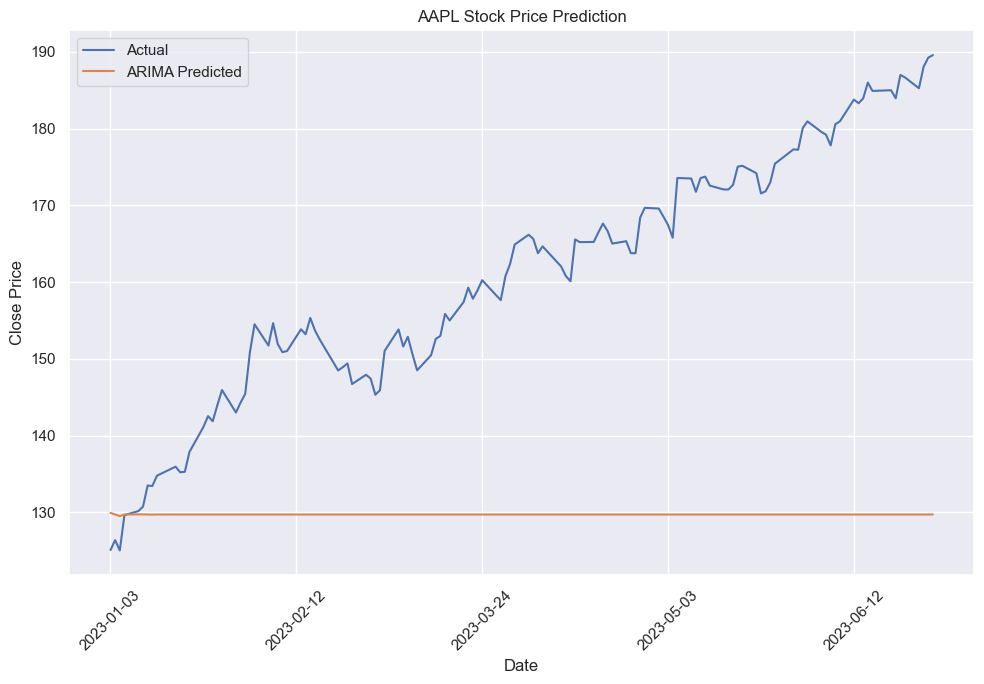

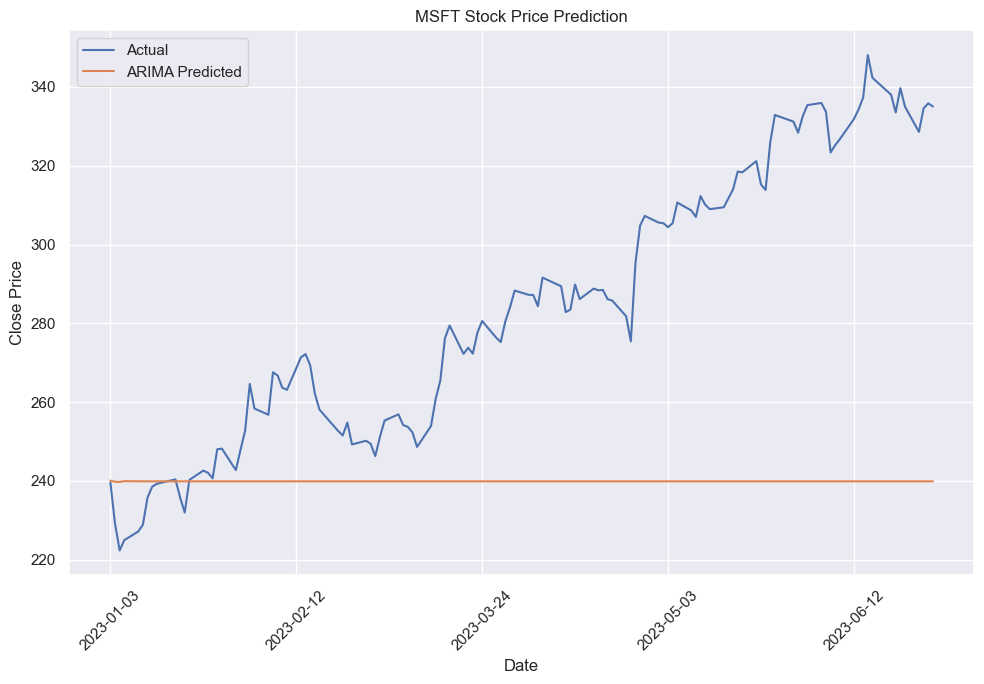

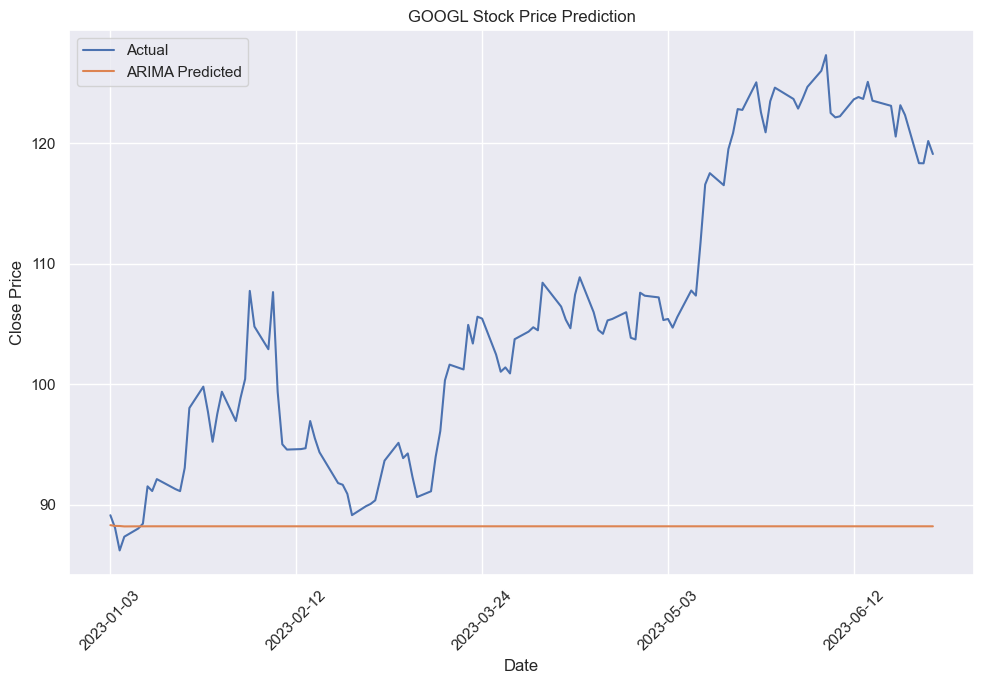

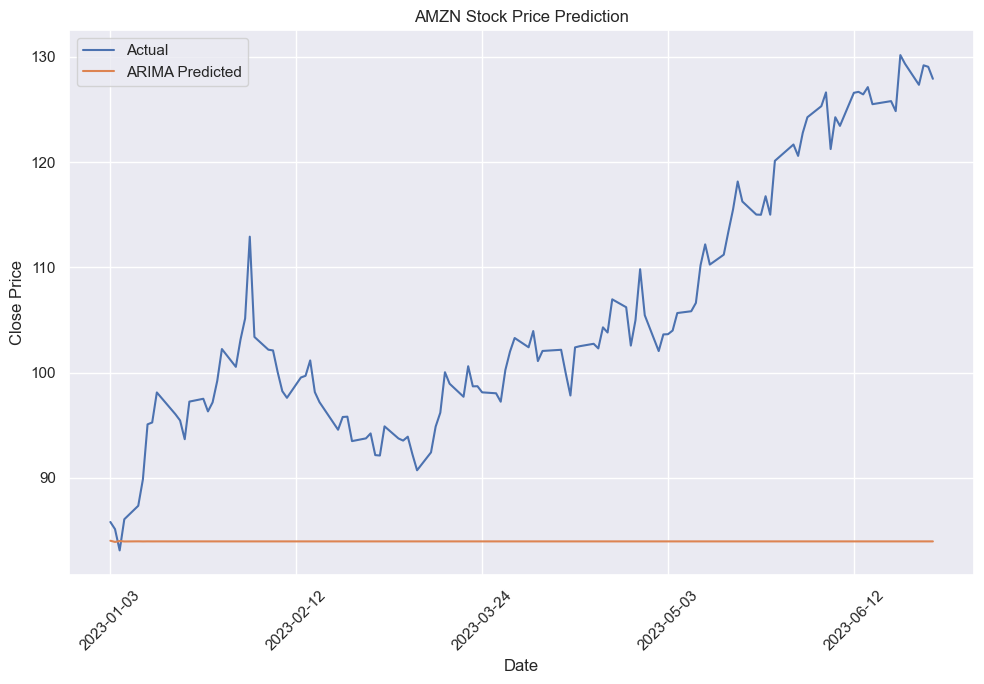

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Ensure that 'Date' column in df_val is of datetime type
df_val['Date'] = pd.to_datetime(df_val['Date'])

for ticker in tickers:
    plt.figure(figsize=(10, 7))
    
    # Plot actual and predicted values
    plt.plot(df_val['Date'], df_val[f'{ticker}_Close'], label='Actual')
    plt.plot(df_val['Date'], arima_predictions[ticker], label='ARIMA Predicted')
    
    plt.title(f'{ticker} Stock Price Prediction')
    
    # Generate and format date range for x-ticks
    date_range = pd.date_range(start=df_val['Date'].min(), end=df_val['Date'].max(), freq='40D')
    formatted_dates = date_range.strftime('%Y-%m-%d')
    plt.xticks(date_range, formatted_dates, rotation=45)
    
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:
def pre_processing(data):
    data['Date'] = pd.to_datetime(data['Date'])

    #setting Date as the index
    data.set_index('Date', inplace=True)

    data.sort_index(inplace=True)

    return data

df_train = pre_processing(df_train)
df_val = pre_processing(df_val)
df_test = pre_processing(df_test)

## LSTM Model

In [9]:

from sklearn.preprocessing import StandardScaler


def scale_data_lstm(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Function to prepare data for LSTM
def prepare_lstm_data(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [10]:
# Prepare data for LSTM and XGBoost for each ticker
seq_length = 60

X_train_lstm, y_train_lstm, X_scaler_lstm = {}, {}, {}
X_valid_lstm, y_valid_lstm = {}, {}
X_test_lstm, y_test_lstm = {}, {}


In [11]:
for ticker in tickers:
    # Prepare data for LSTM
    scaled_train_data_lstm, X_scaler_lstm[ticker] = scale_data_lstm(df_train[f'{ticker}_Close'].values.reshape(-1, 1))
    scaled_valid_data_lstm, _ = scale_data_lstm(df_train[f'{ticker}_Close'].values.reshape(-1, 1))
   
    
    X_train_lstm[ticker], y_train_lstm[ticker] = prepare_lstm_data(scaled_train_data_lstm, seq_length)
    X_valid_lstm[ticker], y_valid_lstm[ticker] = prepare_lstm_data(scaled_valid_data_lstm, seq_length)
   

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input, Dropout


# Define and train LSTM models for each ticker
lstm_models = {}

for ticker in tickers:
    model = Sequential()
    model.add(Input(shape=(X_train_lstm[ticker].shape[1], 1))) 
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

   
    # Train the model
    model.fit(X_train_lstm[ticker], y_train_lstm[ticker], epochs=10, batch_size=32, validation_data=(X_valid_lstm[ticker], y_valid_lstm[ticker]), verbose=0)
    
    # Store the trained model
    lstm_models[ticker] = model




In [13]:
# Evaluate and plot LSTM predictions
lstm_performance = {}

for ticker in tickers:
    # Predictions
    predicted_stock_price_lstm = lstm_models[ticker].predict(X_valid_lstm[ticker])
    predicted_stock_price_lstm = X_scaler_lstm[ticker].inverse_transform(predicted_stock_price_lstm)
    
    # Inverse transform actual prices for evaluation
    actual_stock_price_lstm = X_scaler_lstm[ticker].inverse_transform(y_valid_lstm[ticker])

    # Calculate metrics
    mse_lstm = mean_squared_error(actual_stock_price_lstm, predicted_stock_price_lstm)
    mae_lstm = mean_absolute_error(actual_stock_price_lstm, predicted_stock_price_lstm)
    rmse_lstm = np.sqrt(mse_lstm)
    
    lstm_performance[ticker] = {'MSE': mse_lstm, 'MAE': mae_lstm, 'RMSE': rmse_lstm}

    # # Plot predictions
    # plt.figure(figsize=(14, 7))
    # plt.plot(df_val.index[-len(predicted_stock_price_lstm):], actual_stock_price_lstm, label='Actual')
    # plt.plot(df_val.index[-len(predicted_stock_price_lstm):], predicted_stock_price_lstm, label='Predicted')
    # plt.title(f'{ticker} Stock Price Prediction with LSTM')
    # plt.xlabel('Date')
    # plt.ylabel('Closing Price')
    # plt.legend()
    # plt.show()

# Display LSTM performance metrics
lstm_performance_df = pd.DataFrame.from_dict(lstm_performance, orient='index')
print("\nLSTM Performance Metrics:")
print(lstm_performance_df)

101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step

LSTM Performance Metrics:
             MSE       MAE      RMSE
AAPL   14.250132  2.824324  3.774935
MSFT   71.596859  5.154680  8.461493
GOOGL   6.121019  1.660116  2.474069
AMZN   12.150819  2.443162  3.485803


In [14]:
lstm_performance_df

,MSE,MAE,RMSE
AAPL,14.250132,2.824324,3.774935
MSFT,71.596859,5.154680,8.461493
GOOGL,6.121019,1.660116,2.474069
AMZN,12.150819,2.443162,3.485803


## Xgboost Model

In [15]:
# Function to prepare data for XGBoost
def prepare_xgb_data(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [16]:
X_train_xgb, y_train_xgb = {}, {}
X_valid_xgb, y_valid_xgb = {}, {}

In [17]:
for ticker in tickers:
    # Prepare data for LSTM
    
    # Prepare data for XGBoost
    X_train_xgb[ticker], y_train_xgb[ticker] = prepare_xgb_data(df_train[f'{ticker}_Close'].values, seq_length)
    X_valid_xgb[ticker], y_valid_xgb[ticker] = prepare_xgb_data(df_val[f'{ticker}_Close'].values, seq_length)
   

In [18]:
import xgboost as xgb
xgb_models = {}

for ticker in tickers:
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(X_train_xgb[ticker], y_train_xgb[ticker])
    
    # Store the trained model
    xgb_models[ticker] = model


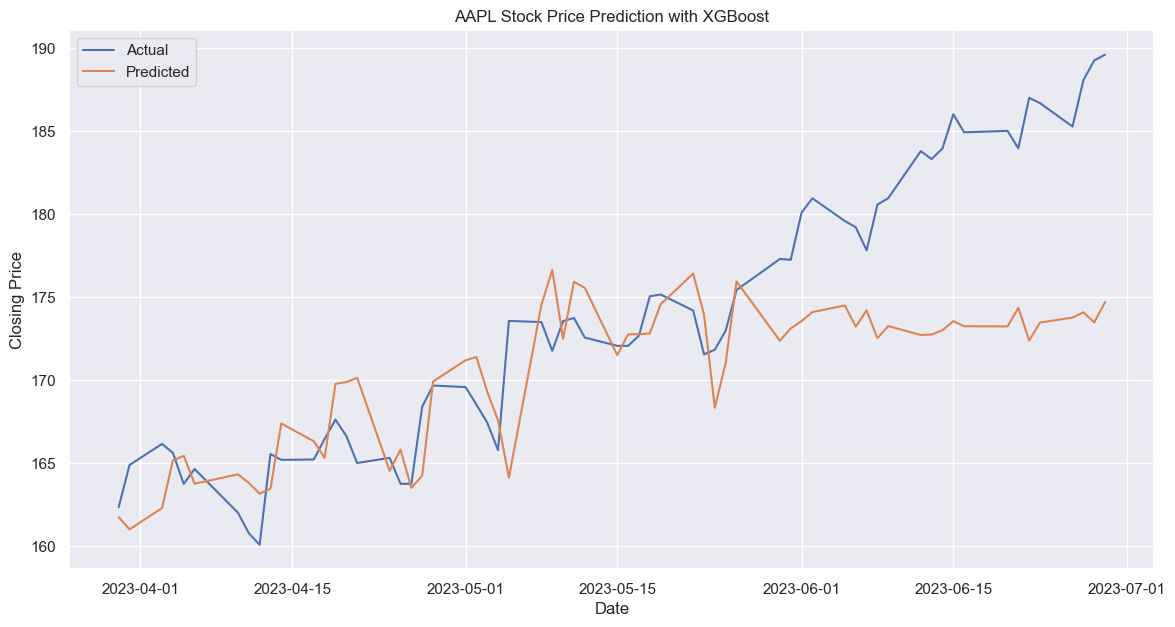

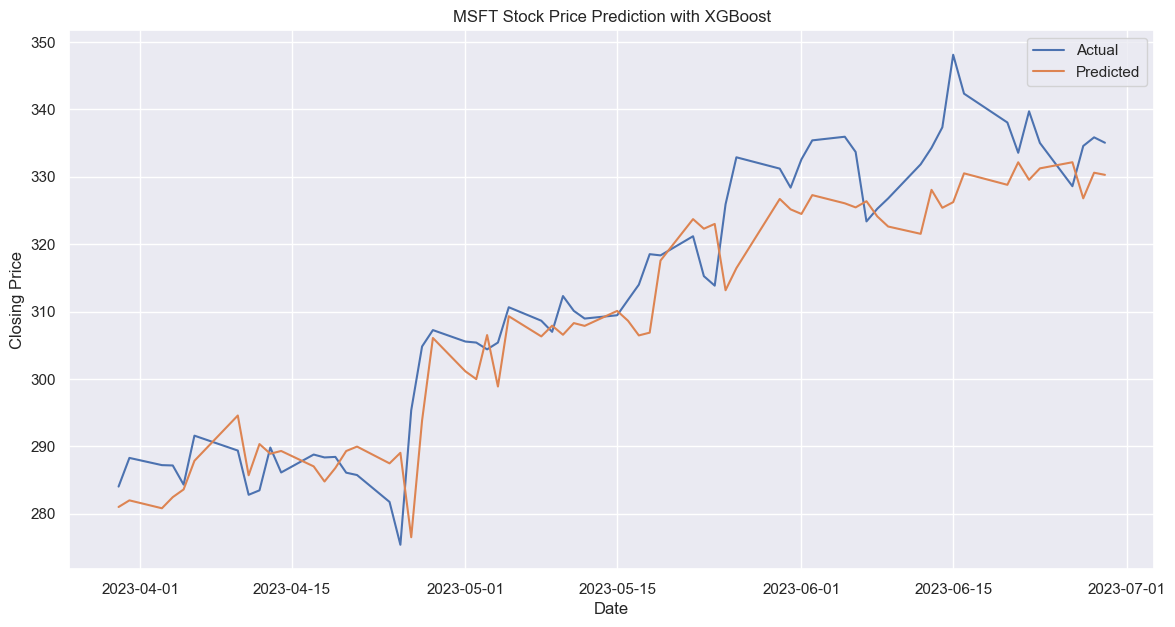

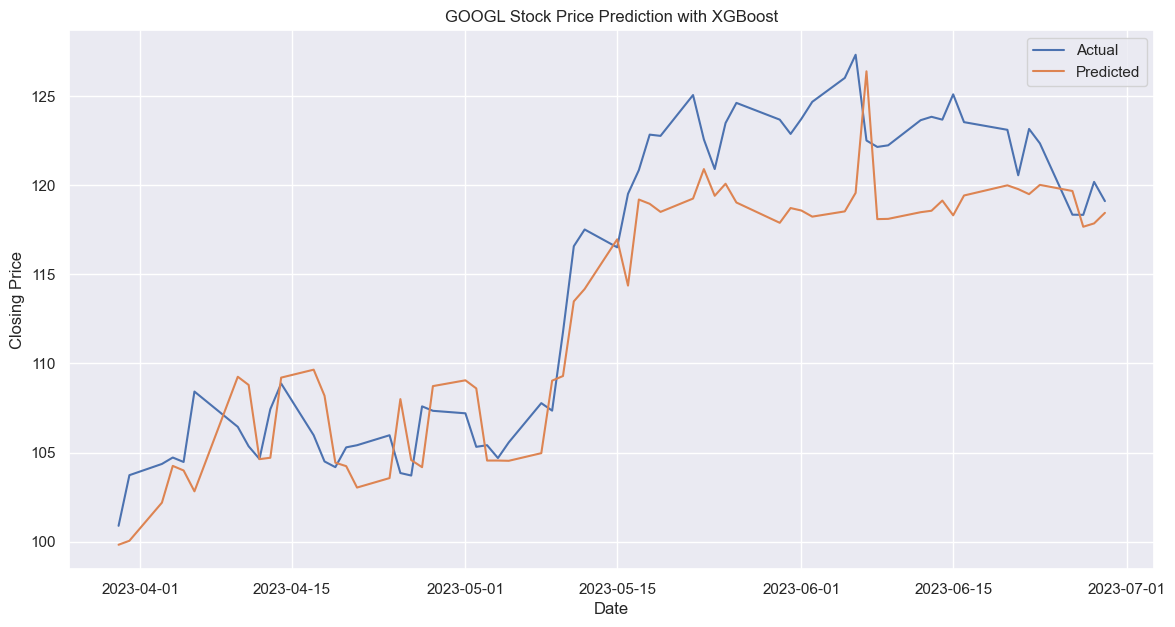

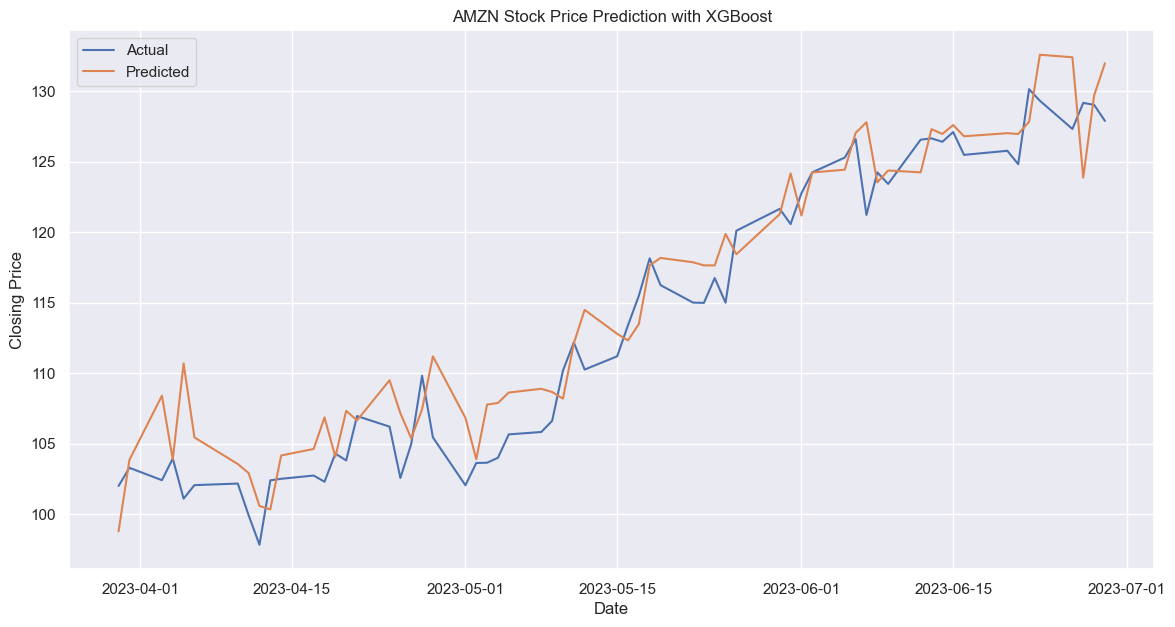


XGBoost Performance Metrics:
             MSE       MAE      RMSE
AAPL   42.901420  4.818158  6.549918
MSFT   55.036981  5.879605  7.418691
GOOGL  12.786904  3.007170  3.575878
AMZN    9.517561  2.422920  3.085054


In [19]:

# Evaluate and plot XGBoost predictions
xgb_performance = {}

for ticker in tickers:
    # Predictions
    predicted_stock_price_xgb = xgb_models[ticker].predict(X_valid_xgb[ticker].reshape(-1, seq_length))
    
    # Calculate metrics
    mse_xgb = mean_squared_error(y_valid_xgb[ticker], predicted_stock_price_xgb)
    mae_xgb = mean_absolute_error(y_valid_xgb[ticker], predicted_stock_price_xgb)
    rmse_xgb = np.sqrt(mse_xgb)
    
    xgb_performance[ticker] = {'MSE': mse_xgb, 'MAE': mae_xgb, 'RMSE': rmse_xgb}

    # Plot predictions
    plt.figure(figsize=(14, 7))
    plt.plot(df_val.index[-len(predicted_stock_price_xgb):], y_valid_xgb[ticker], label='Actual')
    plt.plot(df_val.index[-len(predicted_stock_price_xgb):], predicted_stock_price_xgb, label='Predicted')
    plt.title(f'{ticker} Stock Price Prediction with XGBoost')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

# Display XGBoost performance metrics
xgb_performance_df = pd.DataFrame.from_dict(xgb_performance, orient='index')
print("\nXGBoost Performance Metrics:")
print(xgb_performance_df)

In [20]:
xgb_performance_df

,MSE,MAE,RMSE
AAPL,42.901420,4.818158,6.549918
MSFT,55.036981,5.879605,7.418691
GOOGL,12.786904,3.007170,3.575878
AMZN,9.517561,2.422920,3.085054


Based on the error metrics (MSE, MAE, and RMSE), the **XGBoost model** is the best-performing model for predicting the stock price of these tech giants. It has low errors, indicating better predictive accuracy and generalization on the test data than the ARIMA Model.

It is a lot faster than the LSTM Model.

## Retraining and Prediction

In [21]:
# Combine train and validation data for retraining (optional)
full_train_data = pd.concat([df_train, df_val], axis=0)

In [22]:
full_train_data.head()

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,...,GOOGL_Low,GOOGL_Close,GOOGL_Adj Close,GOOGL_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,AMZN_Adj Close,AMZN_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470740,493729600,30.620001,31.100000,30.590000,30.950001,...,15.621622,15.684434,15.666453,78169752,6.8125,6.8305,6.6570,6.6950,6.6950,151998000
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481928,601904800,30.850000,31.100000,30.639999,30.959999,...,15.554054,15.615365,15.597464,120067812,6.6715,6.7740,6.5905,6.7345,6.7345,177038000
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378825,552160000,30.879999,31.080000,30.520000,30.770000,...,15.174174,15.221722,15.204272,158988852,6.7300,6.7365,6.5825,6.6125,6.6125,143576000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200,30.629999,30.700001,30.190001,30.450001,...,14.831081,14.867367,14.850323,256315428,6.6005,6.6160,6.4400,6.5000,6.5000,220604000
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409363,447610800,30.280001,30.879999,30.240000,30.660000,...,14.742492,15.065566,15.048295,188783028,6.5280,6.6840,6.4515,6.6760,6.6760,196610000


In [23]:
# Function to prepare XGBoost data
def prepare_xgb_data(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)



In [24]:

# Prepare data for XGBoost for each ticker
seq_length = 60

X_train_xgb, y_train_xgb = {}, {}
X_valid_xgb, y_valid_xgb = {}, {}
X_test_xgb, y_test_xgb = {}, {}

for ticker in tickers:
    # Prepare data for XGBoost
    X_train_xgb[ticker], y_train_xgb[ticker] = prepare_xgb_data(full_train_data[f'{ticker}_Close'].values, seq_length)
    X_test_xgb[ticker], y_test_xgb[ticker] = prepare_xgb_data(df_test[f'{ticker}_Close'].values, seq_length)

# Define and train XGBoost models for each ticker
xgb_models = {}

for ticker in tickers:
    model = xgb.XGBRegressor(objective='reg:squarederror')
    model.fit(X_train_xgb[ticker], y_train_xgb[ticker])
    
    # Store the trained model
    xgb_models[ticker] = model



Predicted Prices for AAPL:
[168.16187 168.18834 168.01643 168.25848 170.71843 169.53598 170.80872
 171.37376 172.88925 170.97775 171.54712 174.41953 175.76723 177.78851
 174.82971 178.57542 177.59106 172.07933 167.4272  171.03474 171.1864
 167.62283 164.45276 164.92035 167.87129 168.40808 171.73729 173.64209
 173.99    172.23315 175.98904 180.16399 180.74083 182.32582 184.7221
 184.90361 184.6067  184.72275 185.60422 185.1477  184.57791 185.57547
 185.09953 185.23892 185.07619 186.78323 185.66263 187.78165 186.49268
 187.42392 186.8179  186.61093 185.95691 186.48703 185.54716 185.02599
 185.01938 185.55249 186.0341  185.52843 185.66782 184.90819 185.48987
 185.59871 185.59503 185.46935]


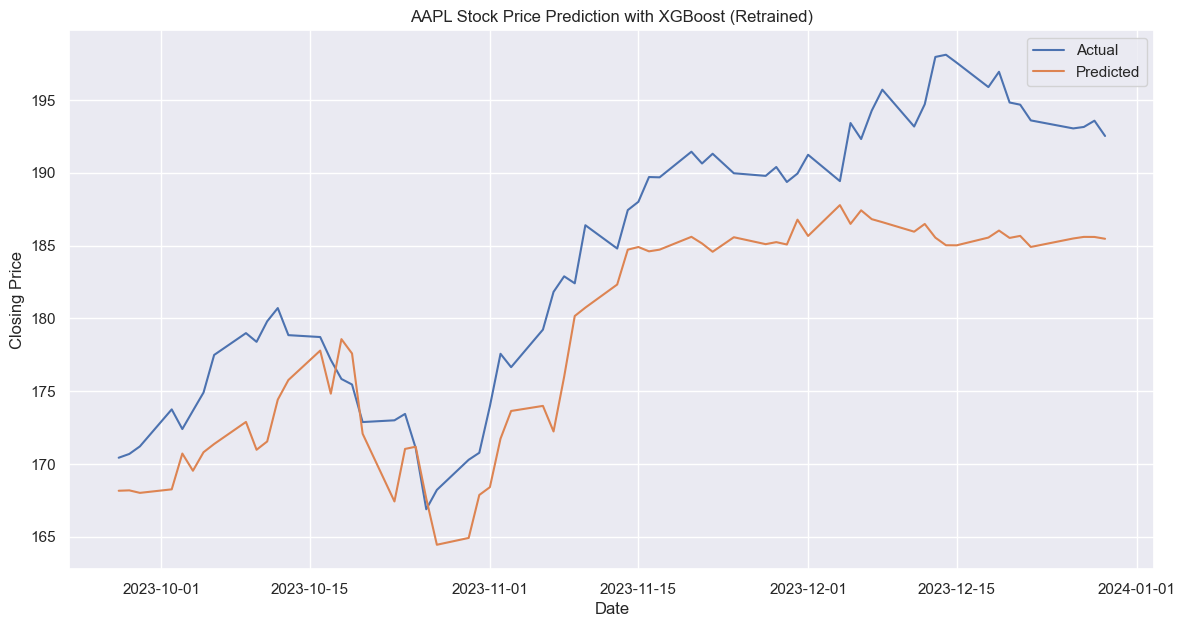

Predicted Prices for MSFT:
[302.16666 304.50293 309.0356  320.10593 315.86234 311.23242 319.9365
 323.3591  330.07098 332.16833 332.367   334.9352  334.28723 331.44257
 334.28323 334.10852 333.6392  333.91818 331.08777 330.90533 333.31693
 336.83545 331.59778 333.39185 334.41135 333.62238 336.38776 334.89215
 335.6819  333.07623 333.70157 332.77023 334.10657 335.8846  337.34152
 334.9218  335.72726 336.81726 335.39905 333.3119  334.91196 335.4681
 331.4161  329.05115 328.99936 329.53958 329.4257  328.99936 329.3718
 329.4257  328.9759  328.9759  328.8735  329.12866 328.8609  328.7901
 328.69498 329.08136 328.70175 327.939   328.37054 326.69278 327.4893
 328.1894  325.84155 325.0462 ]


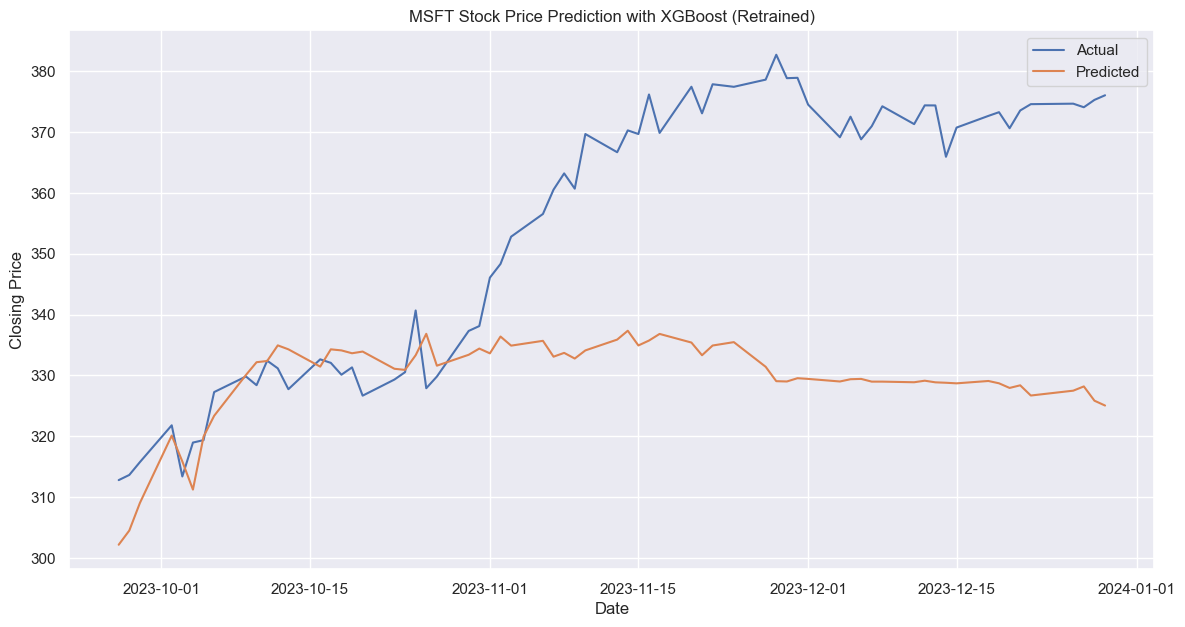

Predicted Prices for GOOGL:
[130.4014   130.94844  131.08786  130.68066  136.13197  130.52794
 136.04982  136.04982  139.89915  139.89915  139.99739  139.92134
 139.98557  138.6211   139.66794  138.45102  138.37814  138.4242
 135.28769  135.95758  139.5602   123.62495  122.71942  121.58469
 123.25313  122.759575 130.38457  129.36172  129.21793  129.90057
 131.71098  130.37079  129.0058   130.21808  130.2151   133.28058
 134.62521  136.02106  134.32088  134.90865  135.9803   138.70297
 136.21036  136.03484  138.19856  134.74957  129.7764   129.87523
 130.72972  129.16063  129.7444   136.12369  134.22389  130.3768
 131.11969  130.13469  130.71367  130.72734  136.16806  136.86885
 140.33629  140.02141  141.46718  140.62318  139.0461   138.80872 ]


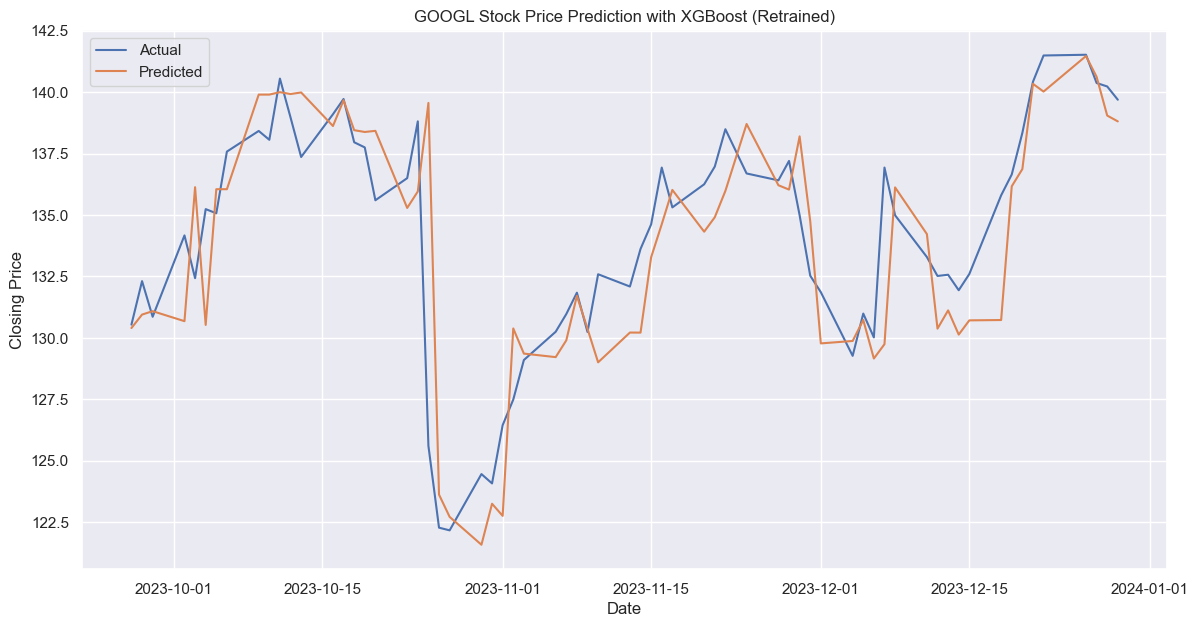

Predicted Prices for AMZN:
[122.99026  124.01982  121.182724 124.646736 129.75688  122.0953
 124.43834  121.971176 130.03722  130.01794  131.8006   134.75572
 134.41774  133.37993  135.6701   134.0741   133.22447  132.75607
 121.87399  123.9555   131.17009  121.74511  118.781654 124.737175
 134.01683  132.81569  138.46996  138.59665  140.96269  143.1613
 144.0639   143.76077  143.89244  143.96594  143.87859  147.94162
 144.21494  142.70706  147.5227   147.22154  142.26588  146.00659
 145.98415  145.70813  145.165    145.30676  145.68166  145.60617
 145.85358  146.0943   142.52803  147.00287  146.8749   146.62527
 147.00287  146.83023  146.83023  147.58386  155.51328  156.1259
 155.2714   154.31184  154.17007  155.3585   155.50027  155.12268 ]


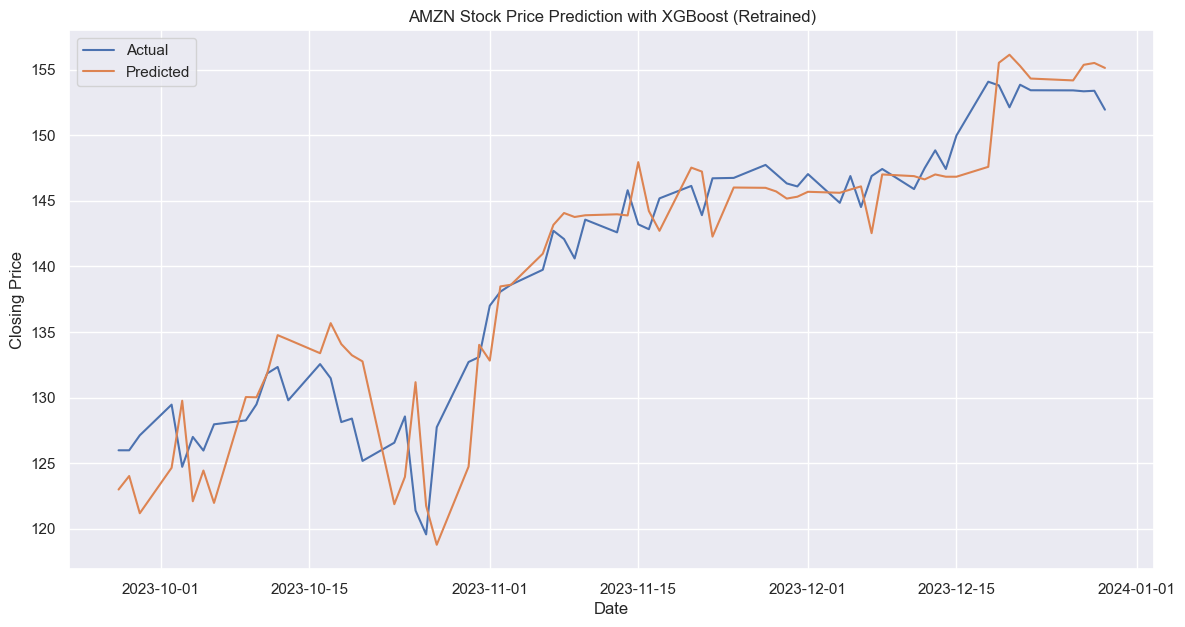

In [25]:
# Predicting new data (second half of 2023) for each ticker using retrained models
predicted_prices = {}

for ticker in tickers:
    # Load the trained XGBoost model for the current ticker
    model = xgb_models[ticker]
    
    # Prepare new data for prediction
    X_new_xgb, _ = prepare_xgb_data(df_test[f'{ticker}_Close'].values, seq_length)
    
    # Make predictions
    predicted_stock_price_xgb = model.predict(X_new_xgb)
    
    # Store predicted prices
    predicted_prices[ticker] = predicted_stock_price_xgb
    
    # Print the predicted prices for the current ticker
    print(f"Predicted Prices for {ticker}:")
    print(predicted_stock_price_xgb)
    
    # Plot predictions
    plt.figure(figsize=(14, 7))
    plt.plot(df_test.index[-len(predicted_stock_price_xgb):], df_test[f'{ticker}_Close'].values[seq_length:], label='Actual')
    plt.plot(df_test.index[-len(predicted_stock_price_xgb):], predicted_stock_price_xgb, label='Predicted')
    plt.title(f'{ticker} Stock Price Prediction with XGBoost (Retrained)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

## Exporting models 

In [26]:
import pickle

models_directory = '../src/models/'

# Export each model
for ticker, model in xgb_models.items():
    model_filename = f'{ticker}_xgb_model.pkl'
    with open(models_directory + model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Exported {ticker} XGBoost model to {model_filename}")


Exported AAPL XGBoost model to AAPL_xgb_model.pkl
Exported MSFT XGBoost model to MSFT_xgb_model.pkl
Exported GOOGL XGBoost model to GOOGL_xgb_model.pkl
Exported AMZN XGBoost model to AMZN_xgb_model.pkl
